In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp

import matplotlib.pyplot as plt

import warnings
import os
import time
import math
import requests

import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('numeric_df.csv')
data.head()

,home_team_elo,away_team_elo,home_xG_to_date,away_xG_to_date,home_xG_against_to_date,away_xG_against_to_date,home_goals_scored_to_date,away_goals_scored_to_date,home_goals_conceded_to_date,away_goals_conceded_to_date,home_points_to_date,away_points_to_date,home_form,away_form,match_result
0,1848.286499,1716.994873,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0
1,1583.799805,1866.807007,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
2,1909.399658,1628.988403,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
3,1642.862427,1475.799316,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
4,1751.501343,1662.613770,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0


In [5]:
# Define the features and target variable
X = data.drop('match_result', axis=1)
y = data['match_result']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the multinomial logistic regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_model.fit(X_train, y_train)




LogisticRegression(multi_class='multinomial')

In [7]:
# Predict on the test set
y_pred = logistic_model.predict(X_test)

# Generate a classification report
class_report = classification_report(y_test, y_pred, target_names=['Home Win', 'Draw', 'Home Loss'])

print(class_report)

              precision    recall  f1-score   support

    Home Win       0.55      0.77      0.64       195
        Draw       1.00      0.01      0.02       110
   Home Loss       0.55      0.66      0.60       151

    accuracy                           0.55       456
   macro avg       0.70      0.48      0.42       456
weighted avg       0.66      0.55      0.48       456



In [10]:
# Fit the model with the original y target (non-binarized)
logistic_model_ovr = LogisticRegression(multi_class='ovr')
logistic_model_ovr.fit(X_train, y_train)  # y_train is not binarized

# Predict probabilities for each class
y_prob = logistic_model_ovr.predict_proba(X_test)

# Calculate the AUC ROC score using the binarized y target for the test set
roc_auc_ovr_corrected = roc_auc_score(y_test_bin, y_prob, multi_class="ovr", average="macro")


In [12]:
# Binarize the y_test data for multi-class ROC AUC calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):  # Assuming 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

# Calculate the AUC
macro_auc_roc = auc(all_fpr, mean_tpr)

# Print the AUC
print(f"Macro-average AUC ROC: {macro_auc_roc}")


Macro-average AUC ROC: 0.684133469019752


Macro-Avg computes the AUC ROC for each class and then averages them, mitigating the class imbalance in the target variable

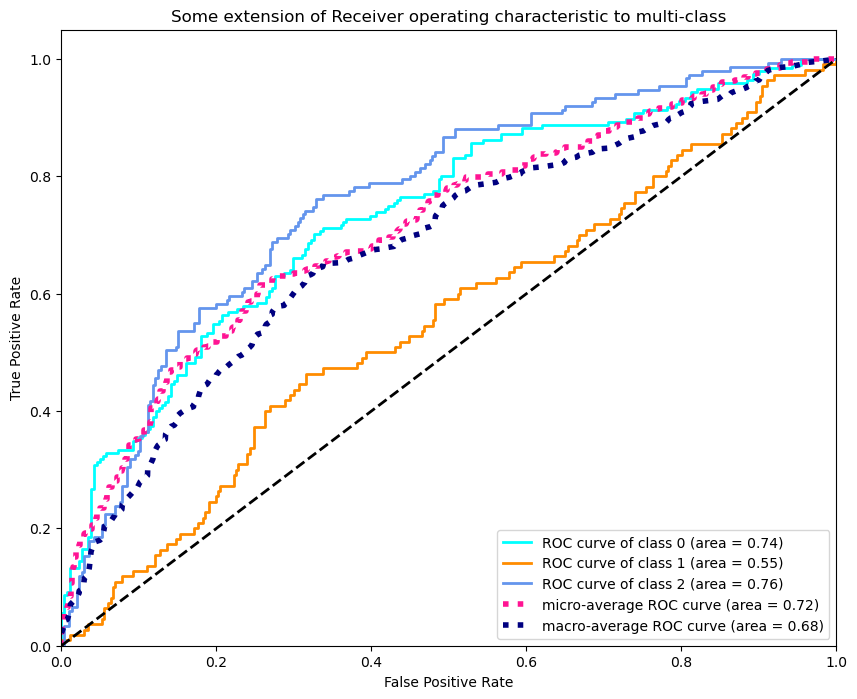

In [17]:
# Assuming logistic_model is your trained logistic regression model
y_prob_ovr = logistic_model_ovr.predict_proba(X_test)

# Binarize the y_test data for multi-class ROC AUC calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob_ovr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob_ovr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))



plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
